In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from metal.contrib.slicing.synthetics.geometric_synthetics import generate_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from metal.contrib.slicing.online_dp import SliceHatModel, MLPModule
from metal.end_model import EndModel

# NOTE: each model can take a "train_kwargs"

### SHARED PIECES
end_model_init_kwargs = {
    "layer_out_dims": [2, 10, 10, 2],
    "verbose": False,
    "n_epochs": 20,
    "lr": 0.1,
    "l2": 1e-7,
}

### FULL CONFIGS
dp_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
}

uni_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
}

up_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "upweight_search_space": {"range": [1, 5]},
    "max_search": 5
}

moe_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "expert_train_kwargs": {"n_epochs": 10, "verbose": False},
    "train_kwargs": {"verbose": False},
    "gating_dim": 5
}

sm_config = {
    "end_model_init_kwargs": end_model_init_kwargs,
    "slice_kwargs": {
        "slice_weight": 0.1,
    }
}


In [3]:
%%time
from collections import defaultdict

from metal.label_model import MajorityLabelVoter
from metal.utils import split_data
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel
from metal.contrib.slicing.experiment_utils import (
    create_data_loader,
    train_model,
    search_upweighting_models,
    eval_model
)
from metal.contrib.slicing.utils import get_L_weights_from_targeting_lfs_idx
from metal.contrib.slicing.mixture_of_experts import train_MoE_model


model_configs = {
#     "UNI": uni_config,
#     "UPx2": up_config,
#     "MoE": moe_config,
    "DP": dp_config,
    "SM": sm_config,
}

NUM_TRIALS = 20
NUM_SLICES = 5
K = 2
M = 20
N = 10000
unipolar = False
pepper = 0.0
print(f"Pepper: {pepper}")
# A base to add to trial number to set a unique seed for each trial
salt = 42 #np.random.randint(1e6)
print(f"Salt: {salt}")


history = defaultdict(list)
for trial in range(NUM_TRIALS):
    print(f"[Trial {trial}]")

    L_kwargs = {'max_r': 7} if unipolar else {'max_r': 5} 
    Z_kwargs = {'num_slices': NUM_SLICES}
    L, X, Y, Z, targeting_lfs_idx = generate_dataset(K, M, N, 
                                                     L_kwargs=L_kwargs,
                                                     Z_kwargs=Z_kwargs,
                                                     unipolar=unipolar,
                                                     return_targeting_lfs=True,
                                                     seed=(salt + trial),
                                                     plotting=False)

    Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.5, 0.25, 0.25], shuffle=True)
    L_train_raw = Ls[0].copy() # TEMP
    
    for model_name, model_config in model_configs.items():
        print ("-"*10, "Training", model_name, "-"*10)

        Ls[0] = L_train_raw.copy() # TEMP: Reset to unpeppered version
        
        # Generate weak labels:
        if model_name == "UNI" or model_name.startswith("UP"):
            Y_train = MajorityLabelVoter().predict_proba(Ls[0])
        else:
            label_model = SnorkelLabelModel()
            label_model.train_model(Ls[0])
            Y_train = label_model.predict_proba(Ls[0])
        Ys[0] = Y_train
        
        from metal.contrib.slicing.utils import add_pepper
        Ls[0] = add_pepper(Ls[0], pepper)        
        
        # Train end model
        if model_name == "UNI":
            L_weights = list(np.ones(M))
            model = train_model(model_config, Ls, Xs, Ys, Zs, L_weights)
        elif model_name.startswith('UP'):
            model = search_upweighting_models(model_config, Ls, Xs, Ys, Zs, 
                                              targeting_lfs_idx, verbose=False)
        elif model_name == "MoE":
            model = train_MoE_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == "DP":
            model = train_model(model_config, Ls, Xs, Ys, Zs)
        elif model_name == "SM":
            model = train_model(model_config, Ls, Xs, Ys, Zs)        
        else:
            raise Exception(f"Unrecognized model_name: {model_name}")
            
        test_loader = create_data_loader(Ls, Xs, Ys, Zs, model_config, 'test')
        results = eval_model(model, test_loader, verbose=False, summary=False)        
        
        # Save results
        history[model_name].append(results)

Pepper: 0.0
Salt: 42
[Trial 0]
---------- Training DP ----------
Added pepper=0.0 random negatives on 0/20 LFs
---------- Training SM ----------
Added pepper=0.0 random negatives on 0/20 LFs
[Trial 1]
At least one slice was clobbered. Trying again.
At least one slice was clobbered. Trying again.
---------- Training DP ----------
Added pepper=0.0 random negatives on 0/20 LFs
---------- Training SM ----------
Added pepper=0.0 random negatives on 0/20 LFs
[Trial 2]
---------- Training DP ----------
Added pepper=0.0 random negatives on 0/20 LFs
---------- Training SM ----------
Added pepper=0.0 random negatives on 0/20 LFs
[Trial 3]
---------- Training DP ----------
Added pepper=0.0 random negatives on 0/20 LFs
---------- Training SM ----------
Added pepper=0.0 random negatives on 0/20 LFs
[Trial 4]
---------- Training DP ----------
Added pepper=0.0 random negatives on 0/20 LFs
---------- Training SM ----------
Added pepper=0.0 random negatives on 0/20 LFs
[Trial 5]
---------- Training DP 

In [4]:
from metal.contrib.slicing.experiment_utils import parse_history

print(f"Average (n={NUM_TRIALS}):")
df = parse_history(history, NUM_SLICES)
df

Average (n=20):


,DP,SM
all,0.629340,0.586680
slice_1,0.573930,0.411782
slice_2,0.683978,0.699569
slice_3,0.571717,0.560119
slice_4,0.723616,0.674244
slice_5,0.609934,0.538055
slice_avg,0.632635,0.576754


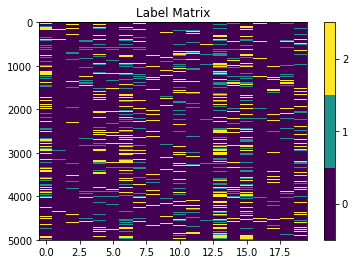

In [5]:
from metal.contrib.visualization.analysis import view_label_matrix
view_label_matrix(Ls[0])